TODO: 
- the basic rnn model should be moving point average, so the output should be a sequence instead of a dot.

In [1]:
# define the RNN model
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        hidden_states = [] # store hidden states for visualization
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate RNN. note the size of h0 is (1 or seq len, batch_size, hidden_size) and x is (batch_size, seq_length, input_size=1)
        # out, hn = self.rnn(x, h0)
        
        ht = h0
        for i in range(x.size(1)):
            out, ht = self.rnn(x[:, i, :].unsqueeze(1), ht)
            hidden_states.append(ht.squeeze(0))
        
        # Pass the output of the last time step to the classifier
        out = self.linear(out) # out: (batch_size, seq_length, hidden_size)
        return out, torch.stack(hidden_states, dim=1) # squeezed to remove the additional dimension added by the batch


Epoch [1/3], Step [1/44], Loss: 0.4543
Epoch [1/3], Step [2/44], Loss: 0.4293
Epoch [1/3], Step [3/44], Loss: 0.2339
Epoch [1/3], Step [4/44], Loss: 0.2223
Epoch [1/3], Step [5/44], Loss: 0.2354
Epoch [1/3], Step [6/44], Loss: 0.1803
Epoch [1/3], Step [7/44], Loss: 0.1401
Epoch [1/3], Step [8/44], Loss: 0.1274
Epoch [1/3], Step [9/44], Loss: 0.1977
Epoch [1/3], Step [10/44], Loss: 0.1333
Epoch [1/3], Step [11/44], Loss: 0.1835
Epoch [1/3], Step [12/44], Loss: 0.1416
Epoch [1/3], Step [13/44], Loss: 0.1597
Epoch [1/3], Step [14/44], Loss: 0.0591
Epoch [1/3], Step [15/44], Loss: 0.0168
Epoch [1/3], Step [16/44], Loss: 0.0381
Epoch [1/3], Step [17/44], Loss: 0.0151
Epoch [1/3], Step [18/44], Loss: 0.0127
Epoch [1/3], Step [19/44], Loss: 0.0167
Epoch [1/3], Step [20/44], Loss: 0.0226
Epoch [1/3], Step [21/44], Loss: 0.0228
Epoch [1/3], Step [22/44], Loss: 0.0412
Epoch [1/3], Step [23/44], Loss: 0.0749
Epoch [1/3], Step [24/44], Loss: 0.0514
Epoch [1/3], Step [25/44], Loss: 0.0696
Epoch [1/

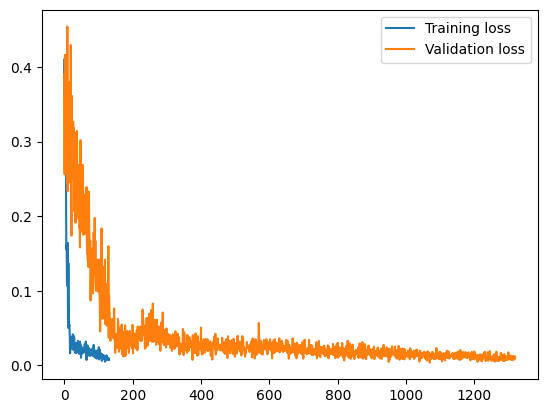

In [2]:
## Train the model
# from src.basic_rnn_model import SimpleRNN
from src.data_generator_2pointavg import MovingAverageDataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn

training_dataset = MovingAverageDataset(sequence_length=10, total_samples=1000)
# Split the dataset into training and validation and test sets
train_size = int(0.7 * len(training_dataset))
val_size = int(0.15 * len(training_dataset))
test_size = len(training_dataset) - train_size - val_size
training_dataset, validation_dataset, test_dataset = random_split(training_dataset, [train_size, val_size, test_size])
training_dataloader = DataLoader(training_dataset, batch_size=16, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Hyper-parameters
input_size = 1
hidden_size = 32
output_size = 1
learning_rate = 0.001
num_epochs = 3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = SimpleRNN(input_size, hidden_size, output_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
training_losses = []
validation_losses = []

total_step = len(training_dataloader)
for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(training_dataloader):
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(sequences)[0]
        outputs = outputs.squeeze()
        training_loss = criterion(outputs, labels)
        training_losses.append(training_loss.item())

        # compute the validation loss
        model.eval()
        with torch.no_grad():
            for val_sequences, val_labels in validation_dataloader:
                val_sequences = val_sequences.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_sequences)[0]
                val_outputs = val_outputs.squeeze()
                val_loss = criterion(val_outputs, val_labels)
                validation_losses.append(val_loss.item())
        model.train()
        
        # Backward and optimize
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()
        
        if (i+1) % 1 == 0: # every 1 steps
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, val_loss.item()))
    torch.save(model, './models/pointavgmodel_epoch'+str(epoch+1)+'_validationloss{:.7f}'.format(val_loss.item())+'.pth')
torch.save(model, './models/model_final.pth')

# compute the test loss
model.eval()
test_losses = []
with torch.no_grad():
    for test_sequences, test_labels in test_dataloader:
        test_sequences = test_sequences.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_sequences)[0]
        test_outputs = test_outputs.squeeze()
        test_loss = criterion(test_outputs, test_labels)
        test_losses.append(test_loss.item())
avg_test_loss = sum(test_losses) / len(test_losses)

# plot the loss
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.plot(training_losses, label='Training loss')    
plt.plot(validation_losses, label='Validation loss')
plt.legend()
plt.savefig('./training_figs/pointavgmodel_epoch'+str(epoch+1)+'_validationloss{:.7f}'.format(val_loss.item())+'_testloss{:.7f}'.format(avg_test_loss)+'.png')



In [3]:
def plot_input_output(sequences, out):
    # create 3 by 1 subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    for i in range(3):
        axs[i].plot(sequences[i], label='Input')
        axs[i].scatter(sequences.shape[1]-1, out[i], label='Output', color='red')
        axs[i].hlines(y=np.mean(sequences[i]), xmax=sequences.shape[1]-1, xmin=0, label='Target', color='green', linestyle='--')
        axs[i].legend()
    plt.show()
    


In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from src.data_generator_2pointavg import MovingAverageDataset
from src.slow_point_finder import *
# Load the model
# model = torch.load('./models/model_final.pth')
model
# Load the dataset and dataloader
dataset = MovingAverageDataset(sequence_length=10, total_samples=900)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# Extract activations
def extract_activations(model, dataloader, device):
    model.eval()
    activations = []  # Store activations here
    sequences_ls = []
    out_ls = []
    with torch.no_grad():
        for sequences, _ in dataloader:
            sequences_ls.append(sequences.numpy())
            sequences = sequences.to(device)
            out, hidden = model(sequences)  # Assuming model returns hidden states and output
            activations.append(hidden.cpu().numpy())
            out_ls.append(out.cpu().numpy())
            # print(sequences.shape, hidden.shape) #torch.Size([1, 10, 1]) torch.Size([1, 10, 32])
    return activations, sequences_ls, out_ls


(900, 10, 32)
(900, 10, 1)
(900, 1, 1)


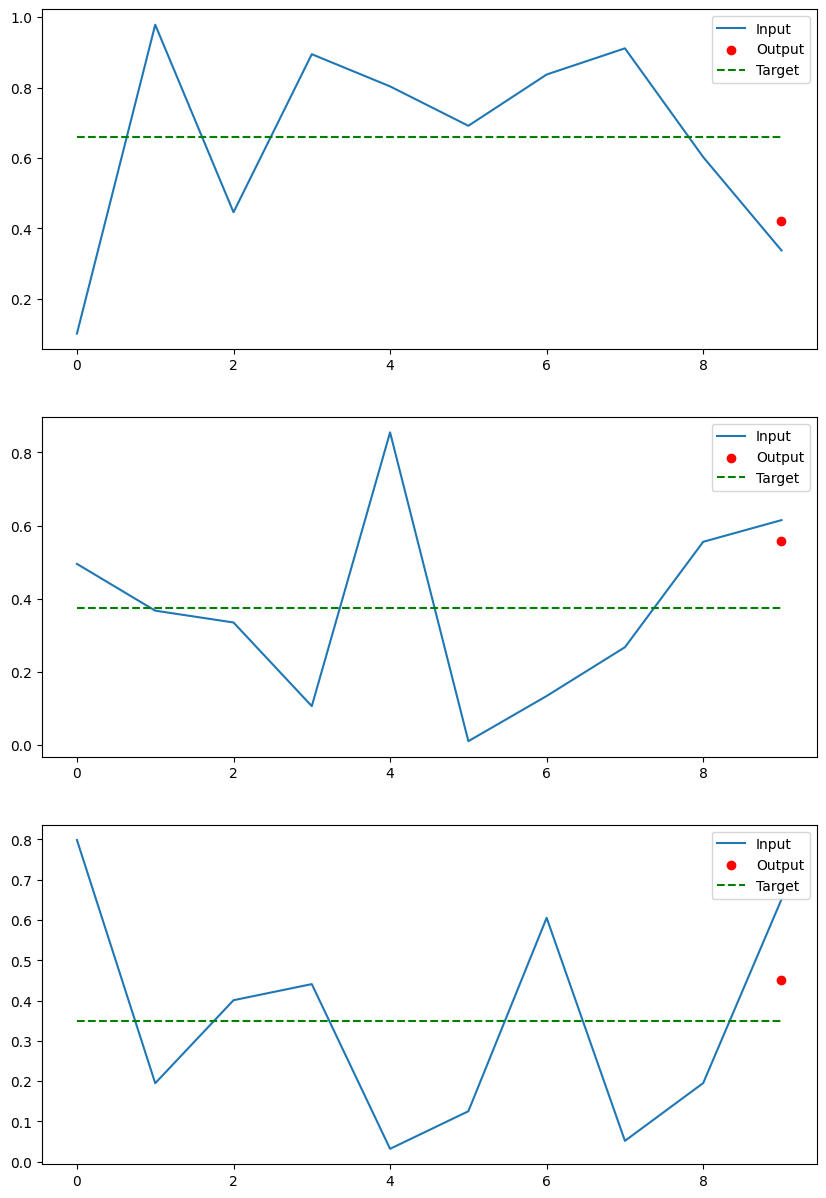

In [5]:
hidden_layers, sequences_list, out_list = extract_activations(model, dataloader, 'cpu')
hidden_layers = np.concatenate(hidden_layers, axis=0)
sequences_list = np.concatenate(sequences_list, axis=0)
out_list = np.concatenate(out_list, axis=0)
print(hidden_layers.shape)
print(sequences_list.shape)
print(out_list.shape)
plot_input_output(sequences_list, out_list)

In [6]:
## find the slow/fixed points
# These are some preliminaries. 
# x_star = np.zeros(u)  # We always linearize the input around zero in this example.
# get one data and label from the dataloader
data, label = next(iter(dataloader))
x_star = data#.numpy()

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : model.rnn(x_star, h)

batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

In [7]:
fp_loss_fun = get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = get_total_fp_loss_fun(rnn_fun)

In [11]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

fp_candidates = hidden_layers #rnn_internals['hiddens']  # was batch x time x dim
fp_candidates = np.reshape(fp_candidates, (-1, hidden_size)) # now batch * time x dim

In [13]:

fp_tols = [0.0001, 0.00001, 0.000001] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}
    
    fps, fp_losses, fp_idxs, fp_opt_details = \
        find_fixed_points(rnn_fun, torch.Tensor(fp_candidates), fp_hps, do_print=True)
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = np.zeros([0, hidden_size])
        
    all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]


Optimizing to find fixed points.


TypeError: params argument given to the optimizer should be an iterable of Tensors or dicts, but got torch.FloatTensor

In [14]:
model.parameters().

<generator object Module.parameters at 0x00000265ECB1A448>